In [1]:
import torch
import wandb
import mylib.utils as utils
from model.resnet4c10q import ResNet20_Q
import matplotlib.pyplot as plt
import numpy as np
from model.q_lib import Conv2d_Q
from mylib.utils import load_CIFAR10
import pandas as pd

device = 'cpu'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def load_wandb_models(wandb_path):
    api = wandb.Api()
    artifact = api.artifact(wandb_path)
    artifact.download(root='./pretrained_model')
    state_dict = torch.load('./pretrained_model/ckpt.pth', map_location=torch.device(device))

    model = ResNet20_Q(a_bit=4, w_bit=2)

    try:
        model.load_state_dict(state_dict['net'])
    except:
        # if the model is wrapped in a module, update all keys in state_dict to remove module.
        state_dict['net'] = {k.replace('module.', ''): v for k, v in state_dict['net'].items()}
        model.load_state_dict(state_dict['net'])

    return model

In [5]:
def nn_traversal(root, layer_name_list, num_row_list, num_zero_list, num_total_list, cant_merge_num_row_list):
    for name, layer in root.named_children():
        if isinstance(layer, Conv2d_Q):
            if layer.in_channels != layer.out_channels:
                continue
            my_tensor = layer.w_q.detach().numpy()
            num_row, cant_merge_num_row = utils.rm_algo(my_tensor)
            cant_merge_num_row_list.append(cant_merge_num_row)
            num_row_list.append(num_row)
            num_total_list.append(len(my_tensor.flatten()))
            num_zero_list.append(np.sum(my_tensor==0))
            layer_name_list.append(name)
        else:
            if len(layer._modules) == 0:
                continue
            # num_row_list_new, num_zero_list_new, layer_name_list_new = nn_traversal(layer, layer_name_list, num_row_list, num_zero_list)
            num_row_list, num_zero_list, layer_name_list, num_total_list, cant_merge_num_row_list = nn_traversal(layer, layer_name_list, num_row_list, num_zero_list, num_total_list, cant_merge_num_row_list)
            
            # num_row_list.append(num_row_list_new)
            # num_zero_list.append(num_zero_list_new)
            # layer_name_list.append(layer_name_list_new)

    return num_row_list, num_zero_list, layer_name_list, num_total_list, cant_merge_num_row_list

In [26]:
# jke1994/ResNet20_WC/model:v189  :  a_bit=4, w_bit=2, eta=0
# jke1994/ResNet20_WC/model:v182  :  a_bit=4, w_bit=2, eta=100

# jke1994/ResNet20_WC/model:v106  :  a_bit=4, w_bit=4, eta=0
# jke1994/ResNet20_WC/model:v111  :  a_bit=4, w_bit=4, eta=100

# jke1994/ResNet20_WC_L1/model:v129 :  a_bit=4, w_bit=4, lambda_kl=0, lambda_l1=0
# jke1994/ResNet20_WC_L1/model:v115 :  a_bit=4, w_bit=4, lambda_kl=100, lambda_l1=0.00001


# model_noWC = load_wandb_models('jke1994/ResNet20_WC_L1/model:v129')
# model_WC = load_wandb_models('jke1994/ResNet20_WC_L1/model:v115')

model_noWC = load_wandb_models('jke1994/ResNet20_WC/model:v106')
model_WC = load_wandb_models('jke1994/ResNet20_WC/model:v111')
train_loader, test_loader = load_CIFAR10(batch_size=128)

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs= inputs.to(device)
        outputs = model_noWC(inputs)
        outputs = model_WC(inputs)
        break

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Files already downloaded and verified
Files already downloaded and verified
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 wi

In [27]:
num_row_list, num_zero_list, layer_name_list, num_total_list, cant_merge_num_row_list = nn_traversal(model_WC, [], [], [], [], [])

print(np.sum(num_row_list))
print(np.sum(np.array(num_total_list) - np.array(num_zero_list)))
print(np.sum(num_total_list))
print(num_total_list)
print(np.array(num_total_list) - np.array(num_zero_list))
print(cant_merge_num_row_list)
print(np.sum(np.array(cant_merge_num_row_list)))
print(num_row_list)

# export num_row_list and num_zero_list to csv
df = pd.DataFrame({'layer_name': layer_name_list, 'num_row': num_row_list, 'num_zero': num_zero_list, 'num_total': num_total_list})
df.to_csv('num_row_zero.csv', index=False)


3928
145236
244224
[2304, 2304, 2304, 2304, 2304, 2304, 9216, 9216, 9216, 9216, 9216, 36864, 36864, 36864, 36864, 36864]
[  552  1174   961  1215  1377  1301  5272  4346  5387  5672  5653 23157
 22571 23173 22223 21202]
[59, 26, 42, 59, 50, 72, 44, 34, 62, 46, 65, 111, 82, 85, 50, 84]
971
[89, 99, 93, 131, 124, 137, 212, 176, 215, 219, 235, 462, 432, 450, 419, 435]


In [28]:
z = np.array(num_zero_list)
t = np.array(num_total_list)

1 - np.sum(z)/np.sum(t)

0.59468356918239

In [29]:
num_row_list, num_zero_list, layer_name_list, num_total_list, cant_merge_num_row_list = nn_traversal(model_noWC, [], [], [], [], [])

print(np.sum(num_row_list))
print(np.sum(np.array(num_total_list) - np.array(num_zero_list)))
print(np.sum(num_total_list))
print(num_total_list)
print(np.array(num_total_list) - np.array(num_zero_list))
print(cant_merge_num_row_list)
print(np.sum(np.array(cant_merge_num_row_list)))
print(num_row_list)

df = pd.DataFrame({'layer_name': layer_name_list, 'num_row': num_row_list, 'num_zero': num_zero_list, 'num_total': num_total_list})
df.to_csv('num_row_zero2.csv', index=False)

4226
139812
244224
[2304, 2304, 2304, 2304, 2304, 2304, 9216, 9216, 9216, 9216, 9216, 36864, 36864, 36864, 36864, 36864]
[  736   787   936   932  1295   791  4724  4275  5184  5337  4703 22470
 22771 22718 21812 20341]
[41, 57, 26, 41, 40, 65, 106, 41, 132, 53, 125, 203, 100, 186, 123, 126]
1465
[81, 123, 93, 116, 119, 125, 251, 186, 261, 224, 260, 509, 461, 501, 468, 448]


In [30]:
z = np.array(num_zero_list)
t = np.array(num_total_list)

1 - np.sum(z)/np.sum(t)

0.5724744496855345

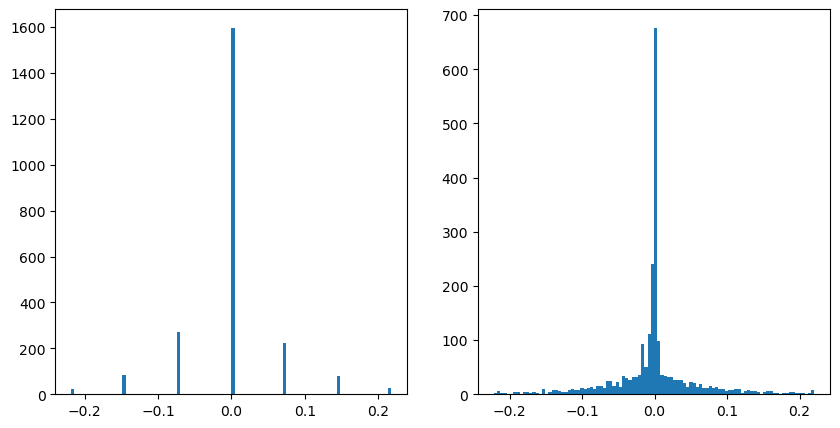

In [7]:
# create a sub figure 1x2
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot for the first sub figure
my_tensor = model_WC.layers_2n[0].conv1.w_q.detach().numpy()
axs[0].hist(my_tensor.flatten(), bins=100);

my_tensor = model_WC.layers_2n[0].conv1.weight.detach().numpy()
axs[1].hist(my_tensor.flatten(), bins=100);

In [9]:
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_44000(inputs)
        break

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
